## Monte Carlo Simulation with VaR

### Setup and Processing of Data

#### Import Libraries

In [32]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#### Import S&P 500 Stock Data

In [45]:
# Download S&P 500 Data (using SPY ETF as proxy)
print("Downloading S&P 500 data...")
ticker = "SPY"
start_date = "2020-08-01"
end_date = "2025-08-02"

# Download data
spy_data = yf.download(ticker, start_date, end_date, auto_adjust=True)
print(f"Data downloaded: {len(spy_data)} trading days")

[*********************100%***********************]  1 of 1 completed

Data downloaded: 1256 trading days


### Generate Daily Returns and Volatility Statistics

#### Calculate Daily Returns

In [34]:
# Calculates daily return percentage
# This will be used for volatility and VaR statistics
spy_data['Daily_Return'] = spy_data['Close'].pct_change()

# Drops NA columns from data for processing
returns = spy_data['Daily_Return'].dropna()

In [35]:
print(f"\nDate Range: {returns.index[0].strftime('%Y-%m-%d')} to {returns.index[-1].strftime('%Y-%m-%d')}")
print(f"Total trading days: {len(returns)}")


Date Range: 2020-08-04 to 2025-08-01
Total trading days: 1255


#### Calculate Daily Returns Statistics

In [36]:
# Calculate Historical Statistics
mean_return = returns.mean()
std_return = returns.std()
skewness = returns.skew()
kurtosis = returns.kurtosis()

print(f"\nHistorical Statistics:")
print(f"  Mean Daily Return: {mean_return:.4f} ({mean_return*252:.2%} annualized)")
print(f"  Daily Volatility: {std_return:.4f} ({std_return*np.sqrt(252):.2%} annualized)")
print(f"  Skewness: {skewness:.4f}")
print(f"  Excess Kurtosis: {kurtosis:.4f}")


Historical Statistics:
  Mean Daily Return: 0.0006 (15.76% annualized)
  Daily Volatility: 0.0110 (17.51% annualized)
  Skewness: 0.2327
  Excess Kurtosis: 8.3010


#### Calculate Daily Returns Value-at-Risk (VAR) at 95% and 99%

In [37]:
# Historical VaR Calculation
historical_var_95 = np.percentile(returns, 5)
historical_var_99 = np.percentile(returns, 1)

print(f"\nHistorical VaR:")
print(f"  95% VaR (worst 5% of days): {historical_var_95:.4f} ({historical_var_95:.2%})")
print(f"  99% VaR (worst 1% of days): {historical_var_99:.4f} ({historical_var_99:.2%})")


Historical VaR:
  95% VaR (worst 5% of days): -0.0171 (-1.71%)
  99% VaR (worst 1% of days): -0.0308 (-3.08%)


### Run Monte Carlo Simulation

In [ ]:
seed = 86 # Determine random seed
np.random.seed(seed) # fixed distribution to seed 

# Simulation parameters
num_simulations = 100000
num_days = len(returns)

# Generate random returns using normal distribution
simulated_returns = np.random.normal(mean_return, std_return, 
                                   (num_simulations, num_days))

# Flatten returns into a 1D array
all_simulated_returns = simulated_returns.flatten()

mc_var_95 = np.percentile(all_simulated_returns, 5)
mc_var_99 = np.percentile(all_simulated_returns, 1)

In [40]:
print(f"Simulations run: {num_simulations:,}")
print(f"Total simulated daily returns: {len(all_simulated_returns):,}")

print(f"\nMonte Carlo VaR:")
print(f"95% VaR: {mc_var_95:.4f} ({mc_var_95:.2%})")
print(f"99% VaR: {mc_var_99:.4f} ({mc_var_99:.2%})")

Simulations run: 100,000
Total simulated daily returns: 125,500,000

Monte Carlo VaR:
95% VaR: -0.0175 (-1.75%)
99% VaR: -0.0250 (-2.50%)


In [47]:
# Compare Results
print(f"\nComparison Analysis:")
print(f"{'Metric':<20} {'Historical':<15} {'Monte Carlo':<15} {'Difference':<15}")
print("-" * 65)
print(f"{'95% VaR':<20} {historical_var_95:.4f}      {mc_var_95:.4f}       {(mc_var_95-historical_var_95):.4f}")
print(f"{'99% VaR':<20} {historical_var_99:.4f}      {mc_var_99:.4f}       {(mc_var_99-historical_var_99):.4f}")



Comparison Analysis:
Metric               Historical      Monte Carlo     Difference     
-----------------------------------------------------------------
95% VaR              -0.0171      -0.0175       -0.0005
99% VaR              -0.0308      -0.0250       0.0058


### Breach Rate Analysis

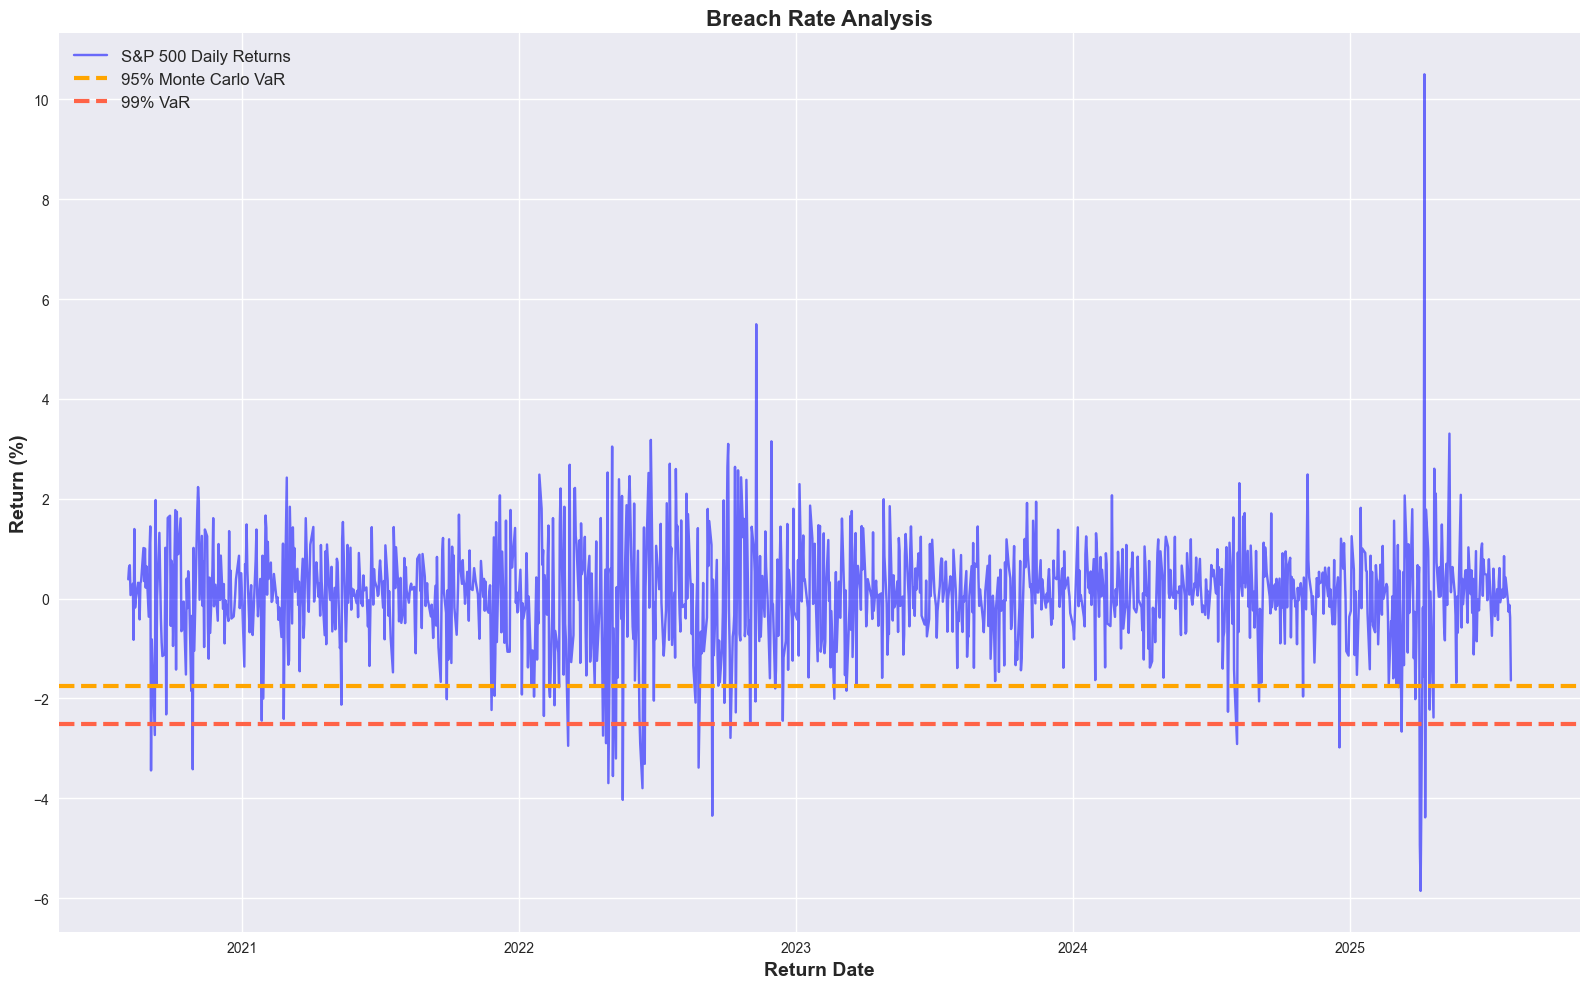

In [50]:
fig = plt.figure(figsize=(16, 10))

plt.plot(returns*100, color='blue', alpha=0.55, label = 'S&P 500 Daily Returns')
plt.axhline(mc_var_95*100, 0, 1255, linestyle='--', linewidth = 3, color='orange', label='95% Monte Carlo VaR')
plt.axhline(mc_var_99*100, 0, 1255, linestyle='--', linewidth = 3,color='tomato', label='99% VaR')

plt.title('Breach Rate Analysis', fontsize=16, fontweight='bold')
plt.xlabel('Return Date', fontsize=14, fontweight='bold')
plt.ylabel('Return (%)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('Breach Analysis.png')
plt.show()



In [43]:
# Days when actual returns were WORSE than our MC VaR prediction
breach_95_count = len(returns[returns < mc_var_95])  # Note: VaR is negative, so < means worse
breach_95_rate = breach_95_count / len(returns)
print(f'95% VaR Breach rate: {round(breach_95_rate*100, 2)}%')

95% VaR Breach rate: 4.62%


In [44]:
# Days when actual returns were WORSE than our MC VaR prediction
breach_99_count = len(returns[returns < mc_var_99])  # Note: VaR is negative, so < means worse
breach_99_rate = breach_99_count / len(returns)
print(f'99% VaR Breach rate: {round(breach_99_rate*100, 2)}%')

99% VaR Breach rate: 1.83%
